In [ ]:
%%bash

FILE=apple2orange
rm -rf ./datasets
mkdir ./datasets

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

mkdir -p ./images/$FILE/

Archive:  ./datasets/apple2orange.zip
   creating: ./datasets/apple2orange/trainA/
  inflating: ./datasets/apple2orange/trainA/n07740461_6908.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_7635.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_586.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_9813.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_6835.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2818.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2918.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_1213.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2476.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_13596.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_4093.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_14738.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_6477.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_11356.jpg  
  inf

for details.

--2022-11-22 12:31:30--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./datasets/apple2orange.zip’

     0K .......... .......... .......... .......... ..........  0%  697K 1m50s
    50K .......... .......... .......... .......... ..........  0%  361K 2m41s
   100K .......... .......... .......... .......... ..........  0% 52.0M 1m48s
   150K .......... .......... .......... .......... ..........  0%  727K 1m47s
   200K .......... .......... .......... .......... ..........  0% 59.6M 86s
   250K .......... .......... .......... .......... ..........  0% 53.4M 72s
   300K .......... .......... .......... .......... ..........  0% 49.9M 62s
   350K .......... ...

In [ ]:
import scipy
import imageio
from skimage.transform import resize
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    # trainA, trainB 불러와서 img_A, img_B로 저장
    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size


        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.7 MB/s 


In [ ]:
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

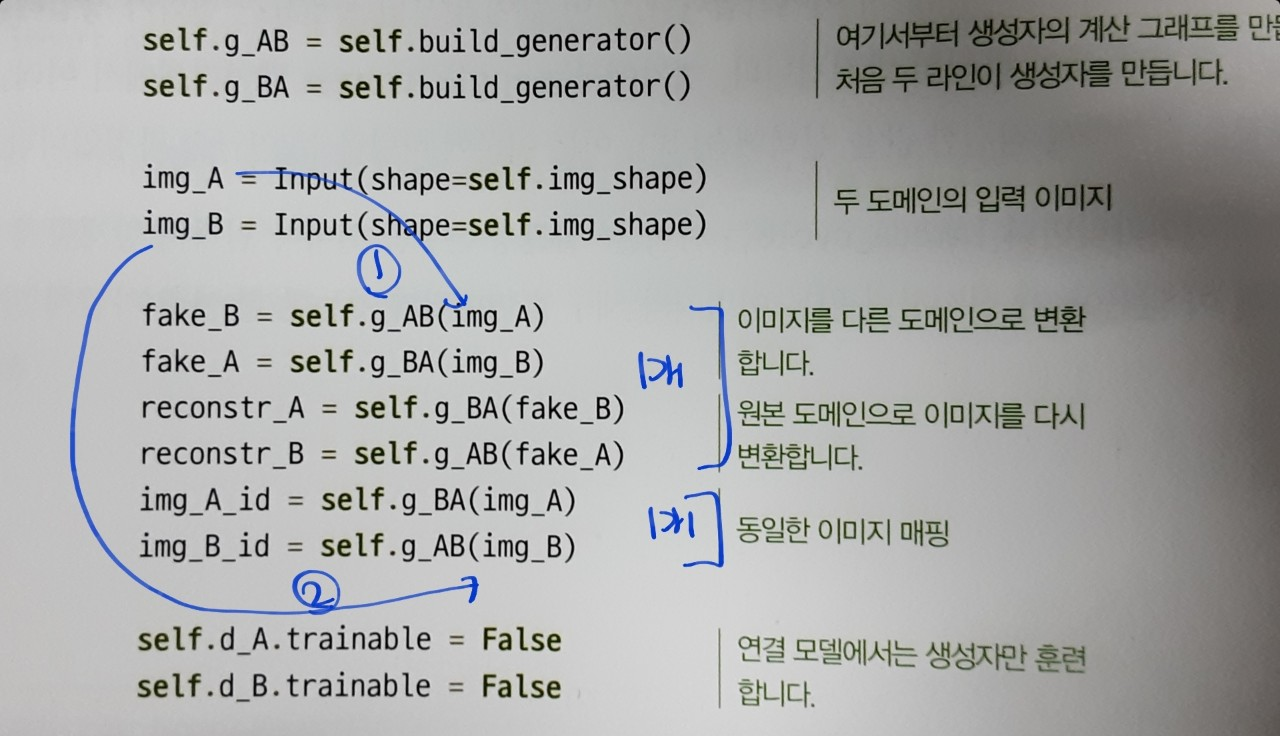

In [ ]:
class CycleGAN():
    def __init__(self):
        # 입력 크기
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # 데이터 로더 설정
        self.dataset_name = 'apple2orange'
        # DataLoader 객체를 사용해 전처리된 데이터 임포트
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # D(PatchGAN)의 출력 크기를 계산 -> 계산대로면 8
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1) # 계산대로면 8, 8, 1

        # G와 D의 첫 번째 층에 있는 필터의 개수
        self.gf = 32
        self.df = 64

        # 손실 가중치
        self.lambda_cycle = 10.0                    # 사이클-일관성 손실
        self.lambda_id = 0.9 * self.lambda_cycle    # 동일성 손실

        optimizer = Adam(0.0002, 0.5)
        
        # 판별자를 만들고 컴파일
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # 생성자의 계산 그래프를 만듭니다.

        # 생성자 선언
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # 두 도메인의 입력 이미지 -> ①, ② 두 번 들어감
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # 이미지를 다른 도메인으로 변환 ①여기
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # 원본 도메인으로 이미지를 다시 변환
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # 동일한 이미지 매핑 ② 여기
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # 연결 모델에서는 생성자만 훈련
        self.d_A.trainable = False
        self.d_B.trainable = False




        # 판별자가 변환된 이미지를 검증
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # 연결 모델은 판별자를 속이기 위한 생성자를 훈련
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B, #판별자의 적대 손실을 위한 출력
                                       reconstr_A, reconstr_B,#재구성을 위한 출력 
                                       img_A_id, img_B_id]) #동일성 손실을 위한 출력

        # 출력의 각 3개의 손실 값
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

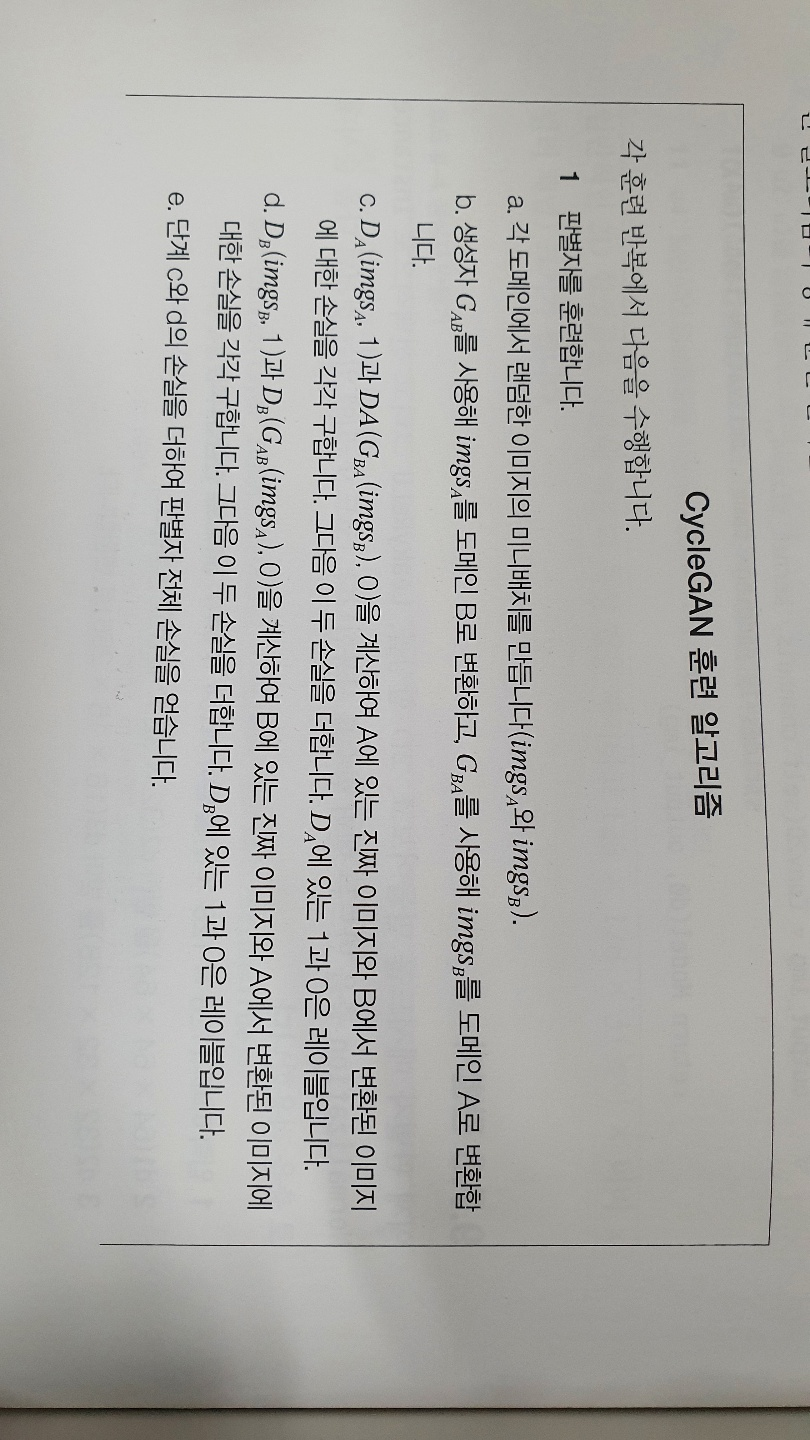

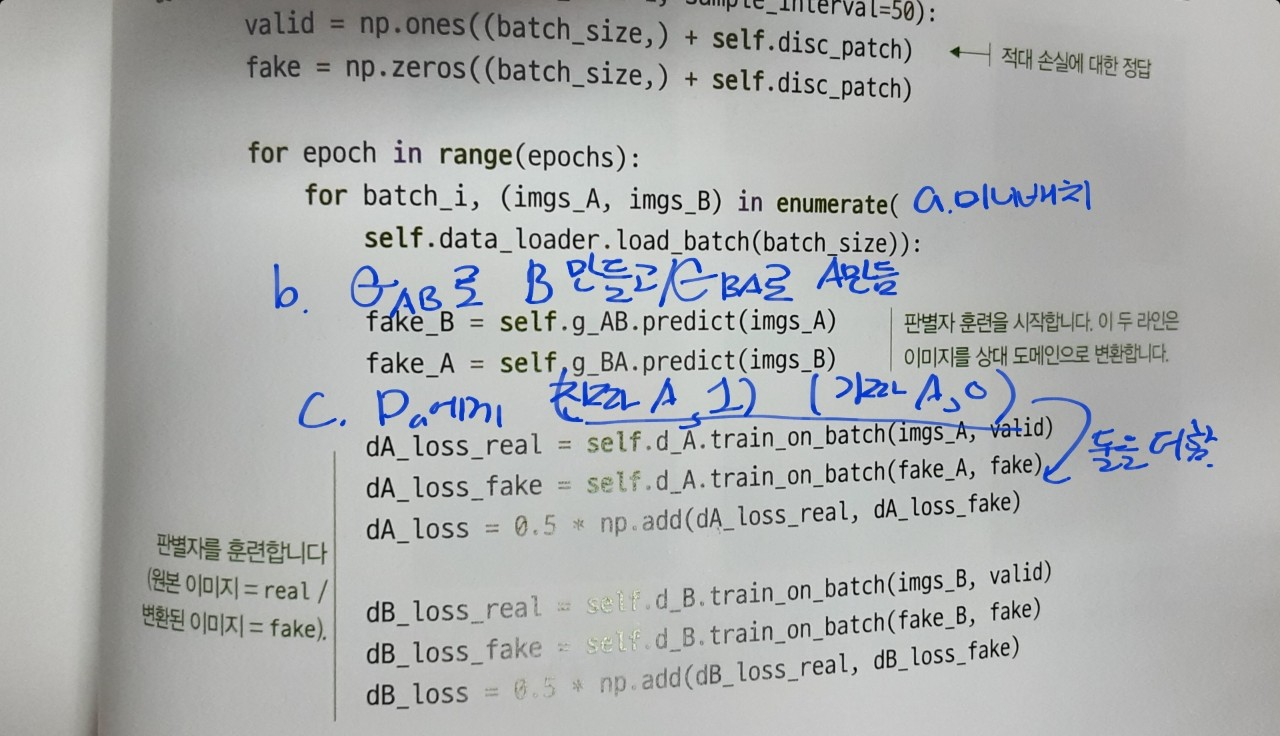

### 각 층

In [ ]:
class CycleGAN(CycleGAN):
      @staticmethod
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        """다운샘플링하는 동안 사용되는 층"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """업샘플링하는 동안 사용되는 층"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

### 생성자

In [ ]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net 생성자"""
        # 이미지 입력
        d0 = Input(shape=self.img_shape)

        # 다운샘플링
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # 업샘플링
        # (d4=그냥 d4입력, d3 = 스킵커넥션)
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

### 판별자

In [ ]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      img = Input(shape=self.img_shape)

      d1 = self.conv2d(img, self.df, normalization=False) #필터 개수를 두배씩 늘린다.
      d2 = self.conv2d(d1, self.df * 2)
      d3 = self.conv2d(d2, self.df * 4)
      d4 = self.conv2d(d3, self.df * 8)

      validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

      return Model(img, validity)

In [ ]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # 이미지를 다른 도메인으로 변환합니다.
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # 원본 도메인으로 되돌립니다.
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # 이미지를 0 - 1 사이로 스케일을 바꿉니다.
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

In [ ]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # 적대 손실에 대한 정답
        valid = np.ones((batch_size,) + self.disc_patch) # 1
        fake = np.zeros((batch_size,) + self.disc_patch) # 0


        for epoch in range(epochs):
          # 각 도메인에서 랜덤한 이미지의 미니배치를 만듬
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                #  판별자 훈련
                # 이미지를 상대 도메인으로 변환

                #생성자 gab를 사용해 이미지a를 b로 변환하고 gba를 사용해 이미지 b를 도메인 a로 변환
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)



                # 판별자를 훈련 (원본 이미지 = real / 변환된 이미지 = fake)
                #da에 실제 이미지a를 1로 알려주고 손실을 구함
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                #gba가 만든 가짜이미지를 0으로 알려줘서 손실을 구함
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                # 이 두 손실을 더함
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)


                # dB에도 똑같이 함
                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # 위에 두 단계에서 나온 손실을 더해서 판별자 전체 손실 생성
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                #  생성자 훈련
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                
                
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

In [ ]:
batch_size = 64
dataset_name = 'apple2orange'
data_loader = DataLoader(img_res=(128, 128), dataset_name=dataset_name)
for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):
  print(imgs_A)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[[[ 0.62334195  0.59178208  0.56825267]
   [ 0.54873353  0.51404672  0.49051731]
   [ 0.49287339  0.46031339  0.43659603]
   ...
   [ 0.49352045  0.46254498  0.44951819]
   [ 0.51334958  0.48199999  0.47289621]
   [ 0.57102874  0.5396562   0.53564165]]

  [[ 0.86871232  0.83909028  0.81593654]
   [ 0.45538539  0.42401238  0.40048319]
   [ 0.08609333  0.05492978  0.03098161]
   ...
   [ 0.04502427  0.01710802 -0.02658878]
   [ 0.22819502  0.19903819  0.17161362]
   [ 0.54394576  0.51376498  0.50122762]]

  [[ 0.95055515  0.92093317  0.90832745]
   [ 0.66758923  0.63621731  0.61310823]
   [ 0.13151364  0.10037421  0.07535068]
   ...
   [-0.19316581 -0.22524011 -0.28915275]
   [ 0.20706464  0.18507609  0.15540628]
   [ 0.52978715  0.52005425  0.50415505]]

  ...

  [[ 0.95086782  0.92493198  0.91491519]
   [ 0.72576246  0.68075617  0.66215059]
   [ 0.41398833  0.31527175  0.29430851]
   ...
   [ 0.05384648  0.0100518  -0.0096906 ]
   [ 0.265661    0.24485869  0.21701379]
   [ 0.54586788 

KeyboardInterrupt: ignored

# Cycle gan 훈련

In [ ]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2/2 [==============================] - 2s 918ms/step


KeyboardInterrupt: ignored